## Задание из 2-х частей.

# Берем отызывы за лето (из архива с материалами или предыдущего занятия)

## Lids

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

from IPython import display

## Load and view

In [2]:
df = pd.read_excel('../data/отзывы за лето.xls')
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [4]:
df.describe()

,Rating
count,20659.000000
mean,4.259015
std,1.348884
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Base vars

In [5]:
MAX_WORDS = 200
MAX_LEN = 0
NUM_CLASSES = 5

# Train vars
EPOCHS = 10
BATCH_SIZE = 64
PRINT_BATCH_N = 100

## Preprocessing
#### X_train

In [6]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [7]:
def preprocess_text(txt):
    txt = str(txt)
    txt = ''.join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    return txt

In [8]:
df['Content'] = df['Content'].apply(preprocess_text)
df.head()

,Rating,Content,Date
0,5,it just works,2017-08-14
1,4,целое удобноной приложениеиз минус хотеть боль...,2017-08-14
2,5,отлично,2017-08-14
3,5,зависать 1 работа антивирус ранее пользоваться...,2017-08-14
4,5,удобно работать быстро,2017-08-14


In [9]:
unique_count_words = np.unique(np.array([len(word_tokenize(text)) for text in df['Content']]))

MAX_LEN = unique_count_words.max()
Q25_LEN = round(np.quantile(unique_count_words, 0.25))
MEAN_LEN = round(unique_count_words.mean())
MEDIAN_LEN = round(np.median(unique_count_words))
Q75_LEN = round(np.quantile(unique_count_words, 0.75))
MIN_LEN = unique_count_words.min()

print(f'MAX: {MAX_LEN}' \
      f'\nQUANTILE_75: {Q75_LEN}' \
      f'\nMEAN: {MEAN_LEN}' \
      f'\nMEDIAN: {MEDIAN_LEN}' \
      f'\nQUANTILE_25: {Q25_LEN}' \
      f'\nMIN: {MIN_LEN}')

MAX: 132
QUANTILE_75: 55
MEAN: 40
MEDIAN: 36
QUANTILE_25: 18
MIN: 0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], test_size=0.3, shuffle=True)

In [11]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()
train_corpus[:100]

'нравиться 😀😀😀 удобно super ужасный приложение стоить официальный прошивка root приложение настаивать'

In [12]:
tokens = word_tokenize(train_corpus)

print(len(tokens))
print(tokens[:5])

70703
['нравиться', '😀😀😀', 'удобно', 'super', 'ужасный']


In [13]:
tokens_filtered = [word for word in tokens if word.isalnum()]

print(len(tokens_filtered))
print(tokens_filtered[:5])

70227
['нравиться', 'удобно', 'super', 'ужасный', 'приложение']


In [14]:
dist = FreqDist(tokens_filtered)
token_filtered_top = [pair[0] for pair in dist.most_common(MAX_WORDS-1)]
token_filtered_top[:5]

['приложение', 'удобно', 'работать', 'удобный', 'отлично']

In [15]:
vocabulary = {v: k for k, v in dict(enumerate(token_filtered_top, 1)).items()}

In [16]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    padding = padding + result[-maxlen:]
    return padding

In [17]:
X_train_bow = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_train], dtype=np.int32)
X_test_bow = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_test], dtype=np.int32)

print(X_train_bow)
print(X_train_bow.shape)

print(X_test_bow)
print(X_test_bow.shape)

[[  0   0   0 ...   0   0   6]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   2]
 ...
 [  0   0   0 ...   0 184  19]
 [  0   0   0 ...   0   0   5]
 [  0   0   0 ...   2  14  18]]
(14461, 132)
[[  0   0   0 ...   0   0   2]
 [  0   0   0 ...   0   0  10]
 [  0   0   0 ...   0   0   6]
 ...
 [  0   0   0 ...   1  16  69]
 [  0   0   0 ...   0   0  63]
 [  0   0   0 ... 127  27  22]]
(6198, 132)


#### y_train

In [18]:
y_train_cat = utils.to_categorical(y_train, num_classes=NUM_CLASSES+1)
y_test_cat = utils.to_categorical(y_test, num_classes=NUM_CLASSES+1)

print(y_train_cat[:5])
print(y_train_cat.shape)

print(y_test_cat[:5])
print(y_test_cat.shape)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]
(14461, 6)
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
(6198, 6)


## 1. Учим conv сеть для классификации

In [19]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    layers.Dense(10),
    layers.Activation('relu'),
    
    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
204/204 [==============================] - 9s 40ms/step - loss: 1.0365 - accuracy: 0.7027 - val_loss: 0.7040 - val_accuracy: 0.7491
Epoch 2/10
204/204 [==============================] - 8s 37ms/step - loss: 0.6571 - accuracy: 0.7734 - val_loss: 0.6892 - val_accuracy: 0.7505
Epoch 3/10
204/204 [==============================] - 7s 36ms/step - loss: 0.6438 - accuracy: 0.7781 - val_loss: 0.6713 - val_accuracy: 0.7567
Epoch 4/10
97/97 [==============================] - 1s 10ms/step - loss: 0.6592 - accuracy: 0.7741
Test score: 0.659171998500824
Test accuracy: 0.7741206884384155


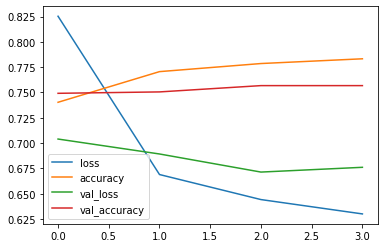

In [21]:
pd.DataFrame(history.history).plot()

97/97 [==============================] - 1s 10ms/step
       y_test  y_pred
idx                  
4058        5       5
15639       5       5
9308        5       5
16289       5       5
10139       5       5
...       ...     ...
13219       4       5
14895       5       5
20404       5       5
2863        3       5
14965       5       5

[6198 rows x 2 columns]


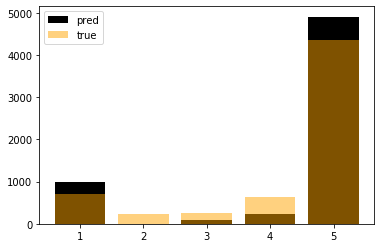

In [22]:
y_pred = model.predict(X_test_bow, batch_size=BATCH_SIZE, verbose=1)
y_pred = pd.Series(y_pred.argmax(axis=1))

result = pd.DataFrame({'idx': y_test.index, 'y_test': y_test.values, 'y_pred': y_pred.values}).set_index('idx')
print(result)

plt.bar(result['y_pred'].value_counts().index, result['y_pred'].value_counts().values, color='black', label='pred')
plt.bar(result['y_test'].value_counts().index, result['y_test'].value_counts().values, alpha=0.5, color='orange', label='true')
plt.legend()
plt.show()

#### Вывод
- Видно, что сложнее всего моделе предсказывать средние оценки (2, 3, 4), возможно из-за того, что люди склонны ставить крайние значения, поэтому о них больше данных
- начиная с 3й похи наблюдается переобучение, по этой причине ранняя остановке прекратила обучение модели

## 2. Берём предобученный word2vec и его эмбедингами инициализируем сетку, как влияет на качество?

In [23]:
import gensim.downloader as api
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [24]:
wv = api.load('glove-twitter-25')

In [25]:
def text_to_wv(text, maxlen):
    result = []
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum()]
    for w in words:
        if w in wv:
            result.append(list(wv[w]))
    padding = [[0]*25]*(maxlen-len(result))
    result = padding + result[-maxlen:]
    return result

In [26]:
X_train_wv = np.array([text_to_wv(text, MAX_LEN) for text in X_train])
X_test_wv = np.array([text_to_wv(text, MAX_LEN) for text in X_test])

print(X_train_wv.shape)
print(X_test_wv.shape)

(14461, 132, 25)
(6198, 132, 25)


In [27]:
model = models.Sequential([
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    layers.Dense(10),
    layers.Activation('relu'),
    
    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_wv, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_wv, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
204/204 [==============================] - 4s 18ms/step - loss: 1.2311 - accuracy: 0.6395 - val_loss: 0.8358 - val_accuracy: 0.7374
Epoch 2/10
204/204 [==============================] - 3s 16ms/step - loss: 0.7677 - accuracy: 0.7487 - val_loss: 0.7443 - val_accuracy: 0.7381
Epoch 3/10
204/204 [==============================] - 3s 16ms/step - loss: 0.7019 - accuracy: 0.7581 - val_loss: 0.7214 - val_accuracy: 0.7491
Epoch 4/10
204/204 [==============================] - 3s 16ms/step - loss: 0.6842 - accuracy: 0.7613 - val_loss: 0.7188 - val_accuracy: 0.7422
Epoch 5/10
204/204 [==============================] - 3s 17ms/step - loss: 0.6480 - accuracy: 0.7770 - val_loss: 0.7113 - val_accuracy: 0.7367
Epoch 6/10
97/97 [==============================] - 0s 4ms/step - loss: 0.7077 - accuracy: 0.7562
Test score: 0.7077237963676453
Test accuracy: 0.7562116980552673


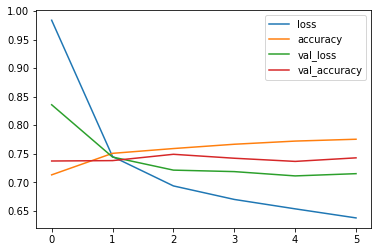

In [29]:
pd.DataFrame(history.history).plot()

97/97 [==============================] - 1s 5ms/step
       y_test  y_pred
idx                  
4058        5       5
15639       5       5
9308        5       5
16289       5       5
10139       5       5
...       ...     ...
13219       4       5
14895       5       5
20404       5       5
2863        3       5
14965       5       5

[6198 rows x 2 columns]


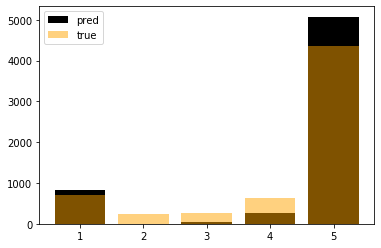

In [30]:
y_pred = model.predict(X_test_wv, batch_size=BATCH_SIZE, verbose=1)
y_pred = pd.Series(y_pred.argmax(axis=1))

result = pd.DataFrame({'idx': y_test.index, 'y_test': y_test.values, 'y_pred': y_pred.values}).set_index('idx')
print(result)

plt.bar(result['y_pred'].value_counts().index, result['y_pred'].value_counts().values, color='black', label='pred')
plt.bar(result['y_test'].value_counts().index, result['y_test'].value_counts().values, alpha=0.5, color='orange', label='true')
plt.legend()
plt.show()

#### Вывод:
- word2vec позволил продолжить обучение дольше чем при кастомной векторизации предложений
- при этом точность модели в итоге стала ниже

## 3. Сравнить разные виды эмбедингов tf.Embeddings word2vec/Fasttext (в качестве агригации попробовать разные виды не только среднее для документа)

In [31]:
df_score = pd.DataFrame(columns=['aggr']).set_index('aggr')

In [32]:
for key, val in {'q25': Q25_LEN, 'mean': MEAN_LEN, 'median': MEDIAN_LEN, 'q75': Q75_LEN, 'max': MAX_LEN}.items():
    
    display.clear_output(wait=False)
    
    model = models.Sequential([
        layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=val),
        layers.Conv1D(filters=128, kernel_size=3),
        layers.Activation('relu'),

        layers.GlobalMaxPool1D(),
        layers.Dense(10),
        layers.Activation('relu'),

        layers.Dense(NUM_CLASSES+1),
        layers.Activation('softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
    early_stopping = callbacks.EarlyStopping(monitor='val_loss')

    history = model.fit(
        X_train_bow, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_split=0.1,
        callbacks=[tensorboard, early_stopping]
    )

    score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

    df_score.loc['aggr', key] = score[1]

Epoch 1/10
204/204 [==============================] - 8s 39ms/step - loss: 1.0299 - accuracy: 0.7070 - val_loss: 0.6896 - val_accuracy: 0.7526
Epoch 2/10
204/204 [==============================] - 8s 40ms/step - loss: 0.6799 - accuracy: 0.7617 - val_loss: 0.6846 - val_accuracy: 0.7581
Epoch 3/10
97/97 [==============================] - 1s 10ms/step - loss: 0.6863 - accuracy: 0.7683


In [33]:
df_score

,q25,mean,median,q75,max
aggr,,,,,
aggr,0.771055,0.763956,0.772185,0.771862,0.768312


#### Вывод:
- число слов в эмбендине практически не повлиятона на точность модели

## 4. По моделировать различные архитектуры сетей (несколько слоёв свёрток с пулингом без с полносвязанными и без них) посмотреть какая архитектура быстрее переобучается, какая более хорошо решает текущую задачу

### +1 Conv

Epoch 1/10
204/204 [==============================] - 22s 107ms/step - loss: 1.0703 - accuracy: 0.7092 - val_loss: 0.7345 - val_accuracy: 0.7443
Epoch 2/10
204/204 [==============================] - 25s 122ms/step - loss: 0.6815 - accuracy: 0.7694 - val_loss: 0.7162 - val_accuracy: 0.7533
Epoch 3/10
204/204 [==============================] - 25s 123ms/step - loss: 0.6477 - accuracy: 0.7826 - val_loss: 0.6838 - val_accuracy: 0.7609
Epoch 4/10
97/97 [==============================] - 2s 24ms/step - loss: 0.6756 - accuracy: 0.7698 0s - loss: 0.686


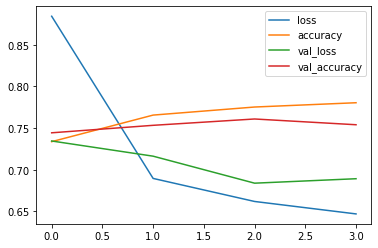

In [34]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    
    layers.Conv1D(filters=128, kernel_size=5),
    layers.Activation('relu'),
    
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    
    layers.Dense(10),
    layers.Activation('relu'),

    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

pd.DataFrame(history.history).plot()

#### Вывод:
- скорость обучения упала

### Dense out

Epoch 1/10
204/204 [==============================] - 19s 89ms/step - loss: 0.9618 - accuracy: 0.7187 - val_loss: 0.7034 - val_accuracy: 0.7478
Epoch 2/10
204/204 [==============================] - 20s 98ms/step - loss: 0.6707 - accuracy: 0.7676 - val_loss: 0.6906 - val_accuracy: 0.7554
Epoch 3/10
204/204 [==============================] - 26s 128ms/step - loss: 0.6488 - accuracy: 0.7797 - val_loss: 0.6903 - val_accuracy: 0.7574
Epoch 4/10
97/97 [==============================] - 3s 31ms/step - loss: 0.6792 - accuracy: 0.7604


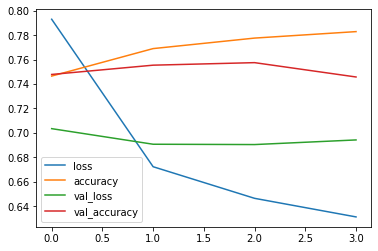

In [35]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    
    layers.Conv1D(filters=128, kernel_size=5),
    layers.Activation('relu'),
    
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    
    layers.Activation('relu'),

    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

pd.DataFrame(history.history).plot()

#### Вывод:
- без полносвязного слоя переобучение наступило раньше